In [37]:
import numpy as np
from numpy import linalg as la
import networkx as nx
import matplotlib.pyplot as plt
import time
import dgl
import torch
from torch import nn
from torch.nn import functional as F

import src.dag_utils as dagu
from src.arch import DAGConv, SF_DAGConv, FB_DAGConv
from src.models import Model, SrcIdModel, AlternatingModel
from src.baselines_archs import GCNN_2L, MyGCNN
from src import utils

SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [38]:
# Auxiliary Functions
def inspect_data(X_data, Y_data, describe=True, plot=True, n_signals_ploted=100):
    print('Summary for X_data:')
    if describe:
        for key, value in X_data.items():
            norm = la.norm(value, 2, axis=1).mean()
            print(f'\t{key}: size: {value.shape}  -  norm: {norm:.3f}')

        print('Summary for Y_data:')
        for key, value in Y_data.items():
            norm = la.norm(value, 2, axis=1).mean()
            print(f'\t{key}: size: {value.shape}  -  norm: {norm:.3f}')

    if not plot:
        return

    X_plot = X_data.numpy()[:n_signals_ploted]
    Y_plot = Y_data.numpy()[:n_signals_ploted]

    # Plot some data
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    img1  = axes[0].imshow(X_plot, cmap='viridis')
    axes[0].set_title('X')
    cbar1 = fig.colorbar(img1, ax=axes[0])
    img2 = axes[1].imshow(Y_plot, cmap='viridis')
    axes[1].set_title('Y')
    cbar2 = fig.colorbar(img2, ax=axes[1])
    plt.tight_layout()

def plot_results(results, errs, times, src_id=False, logy=True):
    for key, value in errs.items():
        if src_id:
            print(f'- {key}: Acc: {value:.3f}  -  Time: {times[key]:.2f}')
        else:
            print(f'- {key}: Mean err: {value[0]:.3f}  -  Std: {value[1]:.3f}  -  Time: {times[key]:.2f}')

    plot_fn = plt.semilogy if logy else plt.plot
    for key, value in results.items():
        plt.figure(figsize=(3.5, 3.5))
        plot_fn(value['train'], label='Train')
        plot_fn(value['val'], label='Val')
        plot_fn(value['test'], label='Test')
        plt.legend()
        plt.title(f'{key}')

GSO computed: 0.12206482887268066


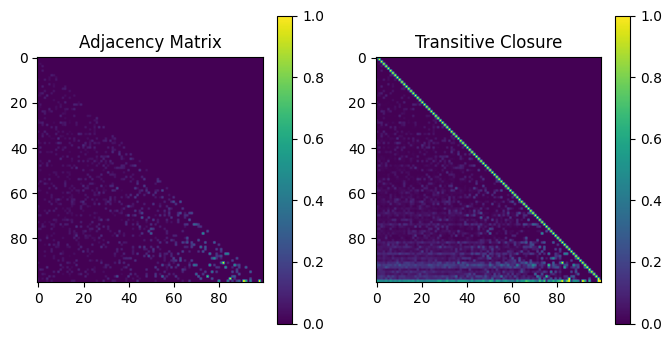

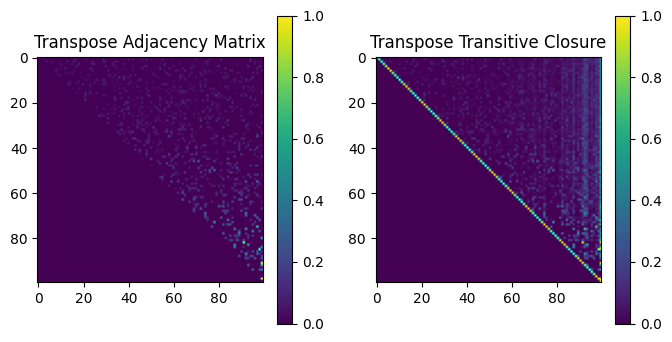

In [39]:
# Create graph
N = 100
p = .2

t_i = time.time()
Adj, dag = dagu.create_dag(N, p)
W = la.inv(np.eye(N) - Adj)
W_inv = la.inv(W)
GSOs = np.array([(W * dagu.compute_Dq(dag, i, N)) @ W_inv for i in range(N)])
print('GSO computed:', time.time()-t_i)

dag_T = nx.from_numpy_array(Adj, create_using=nx.DiGraph())
W_T_inv = la.inv(W.T)
GSOs_T = np.array([(W.T * dagu.compute_Dq(dag_T, i, N)) @ W_T_inv for i in range(N)])


# Plot graph
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im1 = axs[0].imshow(Adj, cmap='viridis')
axs[0].set_title('Adjacency Matrix')
im2 = axs[1].imshow(W, cmap='viridis')
axs[1].set_title('Transitive Closure')
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])

# Plot Transpose Graph
# Plot graph
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im1 = axs[0].imshow(Adj.T, cmap='viridis')
axs[0].set_title('Transpose Adjacency Matrix')
im2 = axs[1].imshow(W.T, cmap='viridis')
axs[1].set_title('Transpose Transitive Closure')
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])


# Example 1: modeling diffusion

In [4]:
# Create DATA
M = 2000
M_train = int(.7*M)
M_val = int(.2*M)
M_test = int(.1*M)
max_src_node = 25  # 5
n_sources = 5
n_p = .1
max_GSO = 100
min_GSO = 50
n_GSOs = 25

range_GSO = np.arange(min_GSO, max_GSO)
gsos_idx = np.random.choice(range_GSO, size=n_GSOs, replace=False)
sel_GSOs = GSOs[gsos_idx]
Y, X = dagu.create_diff_data(M, sel_GSOs, max_src_node, n_p, n_sources, src_t='random',
                                  norm_y='l2_norm', norm_f_coefs=False, ftype='normal')


X_t = torch.Tensor(X)
Y_t = torch.Tensor(Y)

X_data = {'train': X_t[:M_train], 'val': X_t[M_train:-M_test], 'test': X_t[-M_test:]}
Y_data = {'train': Y_t[:M_train], 'val': Y_t[M_train:-M_test], 'test': Y_t[-M_test:]}


In [5]:
inspect_data(X_data, Y_data, plot=True, n_signals_ploted=N)

Summary for X_data:
	train: size: torch.Size([1400, 100, 1])  -  norm: 2.208
	val: size: torch.Size([400, 100, 1])  -  norm: 2.216
	test: size: torch.Size([200, 100, 1])  -  norm: 2.219
Summary for Y_data:
	train: size: torch.Size([1400, 100, 1])  -  norm: 1.222
	val: size: torch.Size([400, 100, 1])  -  norm: 1.223
	test: size: torch.Size([200, 100, 1])  -  norm: 1.218


AttributeError: 'dict' object has no attribute 'numpy'

In [ ]:
# Create DAGConv model
in_dim = X.shape[2]
hid_dim = 64
out_dim = Y.shape[2]
L = 2  # 2
l_act = None #nn.Sigmoid()
n_rand_GSOs = 5
loss = nn.MSELoss(reduction='mean')

X_train = torch.Tensor(X_data['train']).to(device)

# Training params
eval_freq = 1
batch_size = 25
lr = 5e-4 #1e-3
epochs = 25
patience = 10
wd = 1e-4
bias = True
verbose = True
errs = {}
results = {}
times = {}
GSOs_tensor = torch.Tensor(GSOs)
sel_GSOs = GSOs_tensor[gsos_idx]
rnd_idx = np.random.choice(N, size=n_rand_GSOs, replace=False)
rnd_sel_GSO = GSOs_tensor[rnd_idx]


# ##############   DAGCNN   ##############
# print('DAGCNN')
# arch = DAGConv(in_dim, hid_dim, out_dim, GSOs_tensor.shape[0], L, last_act=l_act).to(device)
# model = Model(arch, loss, device=device)
# t_i = time.time()
# losses = model.fit(X_data, Y_data, GSOs_tensor, lr, epochs, batch_size, wd, eval_freq=eval_freq,
#                        patience=patience, verb=True)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['DAG'] = model.test(X_data['test'], Y_data['test'], GSOs_tensor)
# results['DAG'] = losses
# times['DAG'] = t_e
# ###########################################


##########   DAGCNN - Sel GSOs   ##########
print('DAGCNN WITH SELECTED GSOs')
arch = DAGConv(in_dim, hid_dim, out_dim, K=sel_GSOs.shape[0], n_layers=L, last_act=l_act, bias=bias)
model = Model(arch, loss, device=device)
t_i = time.time()
losses = model.fit(X_data, Y_data, sel_GSOs, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                             patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['DAG-Prior'] = model.test(X_data['test'], Y_data['test'], sel_GSOs)
results['DAG-Prior'] = losses
times['DAG-Prior'] = t_e
#############################################


##########   DAGCNN - Rand GSOs   ##########
print('DAGCNN Random GSOs')
arch = DAGConv(in_dim, hid_dim, out_dim, K=rnd_sel_GSO.shape[0], n_layers=L, last_act=l_act, bias=bias)
model = Model(arch, loss, device=device)
t_i = time.time()
losses = model.fit(X_data, Y_data, rnd_sel_GSO, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                             patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['DAG-Rand'] = model.test(X_data['test'], Y_data['test'], rnd_sel_GSO)
results['DAG-Rand'] = losses
times['DAG-Rand'] = t_e
#############################################


# CURRENTY NOT WORKING
# print('Alt DAGCNN WITH SELECTED GSOs')
# sel_GSOs = GSOs_tensor[gsos_idx]
# arch_alt = DAGConv(in_dim, hid_dim, out_dim, L, sel_GSOs, last_act=l_act, bias=bias).to(device)
# model = AlternatingModel(arch_alt, loss, 1, 1, device=device)
# t_i = time.time()
# losses_dag_prior = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
#                              patience=patience, verb=verbose, track_test_err=True)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['Alt-DAG-Prior'] = model.test(X_data['test'], Y_data['test'])
# results['Alt-DAG-Prior'] = losses_dag_prior
# times['Alt-DAG-Prior'] = t_e


# print('SF-DAGCNN')
# arch_sf = SF_DAGConv(in_dim, out_dim, L, GSOs_tensor[0], last_act=l_act).to(device)
# model = Model(arch_sf, loss, device=device)
# t_i = time.time()
# losses_dag = model.fit(X_data, Y_data, GSOs_tensor, lr, epochs*10, batch_size, wd, eval_freq=eval_freq,
#                        patience=patience, verb=verbose, track_test_err=True)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['SF-DAG-Prior'] = model.test(X_data['test'], Y_data['test'], GSOs_tensor)
# results['SF-DAG-Prior'] = losses_dag
# times['SF-DAG-Prior'] = t_e


# print('SF-DAGCNN WITH SELECTED GSOs')
# arch_sf = SF_DAGConv(in_dim, out_dim, L, sel_GSOs[0], last_act=l_act).to(device)
# model = Model(arch_sf, loss, device=device)
# t_i = time.time()
# losses_dag = model.fit(X_data, Y_data, sel_GSOs, lr, epochs*10, batch_size, wd, eval_freq=eval_freq,
#                        patience=patience, verb=verbose, track_test_err=True)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['SF-DAG'] = model.test(X_data['test'], Y_data['test'], sel_GSOs)
# results['SF-DAG'] = losses_dag
# times['SF-DAG'] = t_e

# ##############   FB-DAGCNN   ##############
# print('FB-DAGCNN')
# arch = FB_DAGConv(in_dim, hid_dim, out_dim, GSOs_tensor.shape[0], L, last_act=l_act)
# model = Model(arch, loss, device=device)
# t_i = time.time()
# losses_dag = model.fit(X_data, Y_data, GSOs_tensor, lr, epochs, batch_size, wd, eval_freq=eval_freq,
#                        patience=patience, verb=verbose, track_test_err=True)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['FB-DAG'] = model.test(X_data['test'], Y_data['test'], GSOs_tensor)
# results['FB-DAG'] = losses_dag
# times['FB-DAG'] = t_e
# #############################################


##########   FB-DAGCNN - Sel GSOS   ##########
print('FB-DAGCNN WITH SELECTED GSOs')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, K=sel_GSOs.shape[0], n_layers=L, last_act=l_act)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_dag = model.fit(X_data, Y_data, sel_GSOs, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                       patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG-Prior'] = model.test(X_data['test'], Y_data['test'], sel_GSOs)
results['FB-DAG-Prior'] = losses_dag
times['FB-DAG-Prior'] = t_e


##########   FB-DAGCNN - Rand GSOs   ##########
print('FB-DAGCNN Random GSOs')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, K=rnd_sel_GSO.shape[0], n_layers=L, last_act=l_act, bias=bias)
model = Model(arch, loss, device=device)
t_i = time.time()
losses = model.fit(X_data, Y_data, rnd_sel_GSO, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                             patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG-Rand'] = model.test(X_data['test'], Y_data['test'], rnd_sel_GSO)
results['FB-DAG-Rand'] = losses
times['FB-DAG-Rand'] = t_e
###############################################


# #################   GNN - A   #################
# print('CLASSICAL GNN using A')
# S = dgl.from_networkx(nx.from_numpy_array(Adj.T)).add_self_loop().to(device)
# arch = GCNN_2L(in_dim, hid_dim, out_dim)
# model = Model(arch, loss, device=device)
# t_i = time.time()
# losses_gnnA = model.fit(X_data, Y_data, S, lr, epochs, batch_size, wd, eval_freq=1,
#                         patience=patience, verb=verbose, track_test_err=True)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['GNN-A'] = model.test(X_data['test'], Y_data['test'], S)
# results['GNN-A'] = losses_gnnA
# times['GNN-A'] = t_e
# ###############################################


# ################   GNN - GSO   ################
# print('CLASSICAL GNN using GSO')
# S = dgl.from_networkx(nx.from_numpy_array(rnd_sel_GSO[0].numpy())).add_self_loop().to(device)
# arch = GCNN_2L(in_dim, hid_dim, out_dim)
# model = Model(arch, loss, device=device)
# t_i = time.time()
# losses_gnnA = model.fit(X_data, Y_data, S, lr, epochs, batch_size, wd, eval_freq=1,
#                         patience=patience, verb=verbose, track_test_err=True)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['GNN-GSO'] = model.test(X_data['test'], Y_data['test'], S)
# results['GNN-GSO'] = losses_gnnA
# times['GNN-GSO'] = t_e
# ###############################################


# ################   GNN - GSO   ################
# print('CLASSICAL GNN using A')
# S = dgl.from_networkx(nx.from_numpy_array(rnd_sel_GSO[0].T.numpy())).add_self_loop().to(device)
# arch = GCNN_2L(in_dim, hid_dim, out_dim)
# model = Model(arch, loss, device=device)
# t_i = time.time()
# losses_gnnA = model.fit(X_data, Y_data, S, lr, epochs, batch_size, wd, eval_freq=1,
#                         patience=patience, verb=verbose, track_test_err=True)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['GNN-GSOT'] = model.test(X_data['test'], Y_data['test'], S)
# results['GNN-GSOT'] = losses_gnnA
# times['GNN-GSOT'] = t_e
# ###############################################


# #################   GNN - W   #################
# print('CLASSICAL GNN using W')
# S = dgl.from_networkx(nx.from_numpy_array(W.T)).add_self_loop().to(device)
# arch = GCNN_2L(in_dim, hid_dim, out_dim)
# model = Model(arch, loss, device=device)
# t_i = time.time()
# losses_gnnW = model.fit(X_data, Y_data, S, lr, epochs, batch_size, wd, eval_freq=1,
#                         patience=patience, verb=verbose, track_test_err=True)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['GNN-W'] = model.test(X_data['test'], Y_data['test'], S)
# results['GNN-W'] = losses_gnnW
# times['GNN-W'] = t_e
# ###############################################

DAGCNN WITH SELECTED GSOs
Epoch 1/25 - Loss Train: 0.015007 - Val Loss: 0.014062


Epoch 2/25 - Loss Train: 0.008377 - Val Loss: 0.008252
Epoch 3/25 - Loss Train: 0.006473 - Val Loss: 0.006387
Epoch 4/25 - Loss Train: 0.005800 - Val Loss: 0.005745
Epoch 5/25 - Loss Train: 0.005677 - Val Loss: 0.005640
Epoch 6/25 - Loss Train: 0.005656 - Val Loss: 0.005628
Epoch 7/25 - Loss Train: 0.005649 - Val Loss: 0.005625
Epoch 8/25 - Loss Train: 0.005647 - Val Loss: 0.005620
Epoch 9/25 - Loss Train: 0.005646 - Val Loss: 0.005616
Epoch 10/25 - Loss Train: 0.005646 - Val Loss: 0.005612
Epoch 11/25 - Loss Train: 0.005647 - Val Loss: 0.005610
Epoch 12/25 - Loss Train: 0.005649 - Val Loss: 0.005607
Epoch 13/25 - Loss Train: 0.005651 - Val Loss: 0.005605
Epoch 14/25 - Loss Train: 0.005652 - Val Loss: 0.005603
Epoch 15/25 - Loss Train: 0.005651 - Val Loss: 0.005602
Epoch 16/25 - Loss Train: 0.005649 - Val Loss: 0.005601
Epoch 17/25 - Loss Train: 0.005646 - Val Loss: 0.005600
Epoch 18/25 - Loss Train: 0.005643 - Val Loss: 0.005600
Epoch 19/25 - Loss Train: 0.005640 - Val Loss: 0.005601


KeyboardInterrupt: 

Naive error: 2.435722012075207
- DAG-Prior: Mean err: 0.127  -  Std: 0.093  -  Time: 3.64
- DAG-Rand: Mean err: 0.153  -  Std: 0.082  -  Time: 2.61
- FB-DAG-Prior: Mean err: 0.094  -  Std: 0.101  -  Time: 3.92
- FB-DAG-Rand: Mean err: 0.131  -  Std: 0.076  -  Time: 1.02


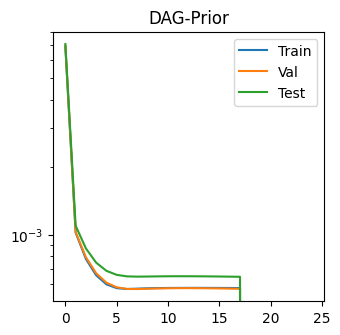

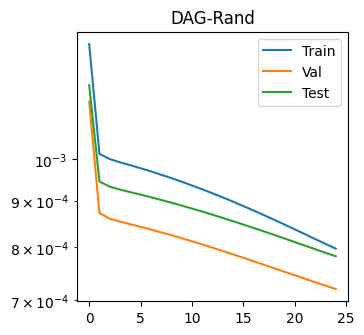

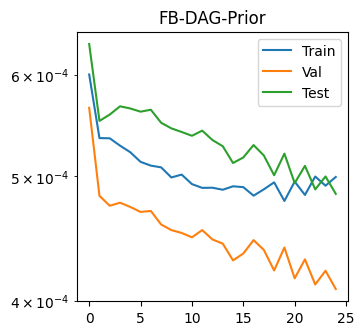

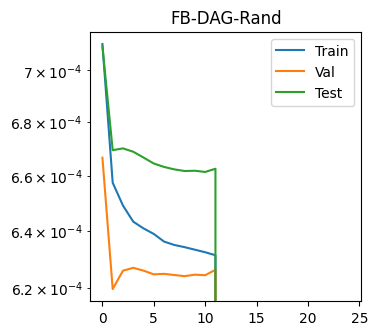

In [ ]:
naive_err = (la.norm(Y-X, 2, axis=1, keepdims=True)/la.norm(Y, 2, axis=1, keepdims=True))**2
naive_err = naive_err.mean()
print('Naive error:', naive_err)
plot_results(results, errs, times)

# Example 2: source identification

In [40]:
# Create DATA
M = 2000
M_train = int(.7*M)
M_val = int(.2*M)
M_test = int(.1*M)
max_src_node = 10  # 5
n_sources = 1
n_p = .05
max_GSO = 100
min_GSO = 50
n_GSOs = 25

range_GSO = np.arange(min_GSO, max_GSO)
gsos_idx = np.random.choice(range_GSO, size=n_GSOs, replace=False)
sel_GSOs = GSOs[gsos_idx]
signals_t, sources_t = dagu.create_diff_data(M, sel_GSOs, max_src_node, n_p, n_sources, src_t='constant',
                                            norm_y='l2_norm', norm_f_coefs=False, torch_tensor=True,
                                            ftype='normal', mask_sources=True)

# Binary labels
labels_t = torch.argmax(torch.abs(sources_t), axis=1)

signals = {'train': signals_t[:M_train], 'val': signals_t[M_train:-M_test], 'test': signals_t[-M_test:]}
labels = {'train': labels_t[:M_train], 'val': labels_t[M_train:-M_test], 'test': labels_t[-M_test:]}


Summary for X_data:


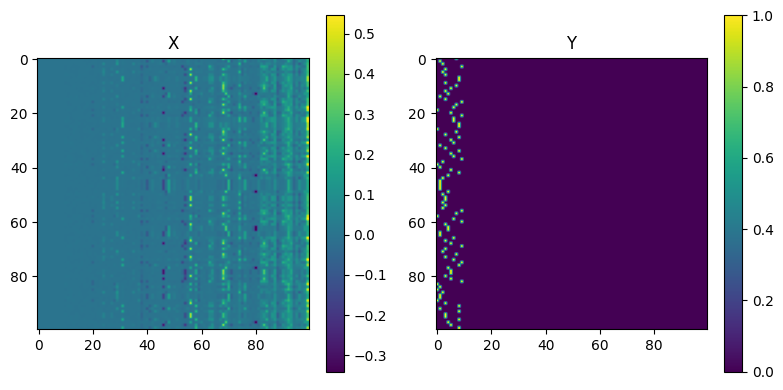

In [41]:
inspect_data(signals['train'], sources_t, describe=False, plot=True, n_signals_ploted=N)

In [45]:
# Create DAGConv model
in_dim = signals_t.shape[2]
hid_dim = 64
out_dim = labels_t.shape[1]
L = 2
l_act = None #F.sigmoid
n_rand_GSOs = 30
loss = nn.CrossEntropyLoss() #nn.BCELoss()
# loss = nn.MSELoss()

# Training params
eval_freq = 1
batch_size = 25 #25
lr = 5e-3 #1e-3
epochs = 100
patience = 10
wd = 1e-4
bias = True
verbose = True
errs = {}
results = {}
times = {}
GSOs_tensor = torch.Tensor(GSOs)
GSOs_T_tensor = torch.Tensor(GSOs_tensor).transpose(1,2)
GSOs_T_tensor2 = torch.Tensor(GSOs_T)
sel_GSOs = GSOs_tensor[gsos_idx]
sel_GSOs_T = GSOs_T_tensor[gsos_idx]
sel_GSOs_T2 = GSOs_T_tensor2[gsos_idx]

rnd_idx = np.random.choice(N, size=n_rand_GSOs, replace=False)
rnd_sel_GSO = GSOs_tensor[rnd_idx]
rnd_sel_GSO_T = GSOs_T_tensor[rnd_idx]
rnd_sel_GSO_T2 = GSOs_T_tensor2[rnd_idx]


##############   FB-DAGCNN   ##############
print('FB-DAGCNN')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, GSOs_tensor.shape[0], L, last_act=l_act)
model = SrcIdModel(arch, device=device)
t_i = time.time()
losses_dag = model.fit(signals, labels, GSOs_tensor, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                       patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG'] = model.test(signals['test'], labels['test'], GSOs_tensor)
results['FB-DAG'] = losses_dag
times['FB-DAG'] = t_e
#############################################


##########   FB-DAGCNN - Sel GSOS   ##########
print('FB-DAGCNN WITH SELECTED GSOs')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, K=sel_GSOs.shape[0], n_layers=L, last_act=l_act)
model_dag = SrcIdModel(arch, loss, device=device)
t_i = time.time()
losses_dag = model_dag.fit(signals, labels, sel_GSOs, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                           patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG-Prior'] = model_dag.test(signals['test'], labels['test'], sel_GSOs)
results['FB-DAG-Prior'] = losses_dag
times['FB-DAG-Prior'] = t_e
#############################################


##########   Transpose FB-DAGCNN - Sel GSOS   ##########
print('FB-DAGCNN WITH SELECTED GSOs Transp')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, K=sel_GSOs.shape[0], n_layers=L, last_act=l_act)
model_dag_T = SrcIdModel(arch, loss, device=device)
t_i = time.time()
losses = model_dag_T.fit(signals, labels, sel_GSOs_T, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                           patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG-Prior-T'] = model_dag_T.test(signals['test'], labels['test'], sel_GSOs_T)
results['FB-DAG-Prior-T'] = losses
times['FB-DAG-Prior-T'] = t_e
#############################################


##########   Transpose v2 FB-DAGCNN - Sel GSOS   ##########
print('FB-DAGCNN WITH SELECTED GSOs Transp')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, K=sel_GSOs.shape[0], n_layers=L, last_act=l_act)
model = SrcIdModel(arch, loss, device=device)
t_i = time.time()
losses = model.fit(signals, labels, sel_GSOs_T2, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                           patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG-Prior-Tv2'] = model.test(signals['test'], labels['test'], sel_GSOs_T2)
results['FB-DAG-Prior-Tv2'] = losses
times['FB-DAG-Prior-Tv2'] = t_e
#############################################


##########   FB-DAGCNN - Rand GSOs   ##########
print('FB-DAGCNN Random GSOs')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, K=rnd_sel_GSO.shape[0], n_layers=L, last_act=l_act, bias=bias)
model = SrcIdModel(arch, loss, device=device)
t_i = time.time()
losses = model.fit(signals, labels, rnd_sel_GSO, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                   patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG-Rand'] = model.test(signals['test'], labels['test'], rnd_sel_GSO)
results['FB-DAG-Rand'] = losses
times['FB-DAG-Rand'] = t_e
###############################################


##########   FB-DAGCNN - Rand GSOs   ##########
print('FB-DAGCNN Random GSOs Transp')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, K=rnd_sel_GSO.shape[0], n_layers=L, last_act=l_act, bias=bias)
model = SrcIdModel(arch, loss, device=device)
t_i = time.time()
losses = model.fit(signals, labels, rnd_sel_GSO_T, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                   patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG-Rand-T'] = model.test(signals['test'], labels['test'], rnd_sel_GSO_T)
results['FB-DAG-Rand-T'] = losses
times['FB-DAG-Rand-T'] = t_e
###############################################


##########   FB-DAGCNN - Rand GSOs Transp v2   ##########
print('FB-DAGCNN Random GSOs Transp v2')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, K=rnd_sel_GSO.shape[0], n_layers=L, last_act=l_act, bias=bias)
model = SrcIdModel(arch, loss, device=device)
t_i = time.time()
losses = model.fit(signals, labels, rnd_sel_GSO_T2, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                   patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG-Rand-Tv2'] = model.test(signals['test'], labels['test'], rnd_sel_GSO_T2)
results['FB-DAG-Rand-Tv2'] = losses
times['FB-DAG-Rand-Tv2'] = t_e
###############################################


#################   GNN - A   #################
print('CLASSICAL GNN using A')
S = torch.Tensor(utils.kipf_GSO(Adj))
arch = MyGCNN(in_dim, hid_dim, out_dim, last_act=l_act)
model = SrcIdModel(arch, loss, device=device)
t_i = time.time()
losses_gnnA = model.fit(signals, labels, S, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-A'] = model.test(signals['test'], labels['test'], S)
results['GNN-A'] = losses_gnnA
times['GNN-A'] = t_e
###############################################


#################   GNN - W   #################
print('CLASSICAL GNN using W')
S = torch.Tensor(utils.kipf_GSO(W))
arch = MyGCNN(in_dim, hid_dim, out_dim, last_act=l_act)
model = SrcIdModel(arch, loss, device=device)
t_i = time.time()
losses_gnnA = model.fit(signals, labels, S, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-W'] = model.test(signals['test'], labels['test'], S)
results['GNN-W'] = losses_gnnA
times['GNN-W'] = t_e
###############################################


#################   GNN - A.T   #################
print('CLASSICAL GNN using A Transp')
S = torch.Tensor(utils.kipf_GSO(Adj.T))
arch = MyGCNN(in_dim, hid_dim, out_dim, last_act=l_act)
model = SrcIdModel(arch, loss, device=device)
t_i = time.time()
losses_gnnA = model.fit(signals, labels, S, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-A-T'] = model.test(signals['test'], labels['test'], S)
results['GNN-A-T'] = losses_gnnA
times['GNN-A-T'] = t_e
###############################################


#################   GNN - W.T   #################
print('CLASSICAL GNN using W Transp')
S = torch.Tensor(utils.kipf_GSO(W.T))
arch = MyGCNN(in_dim, hid_dim, out_dim, last_act=l_act)
model = SrcIdModel(arch, loss, device=device)
t_i = time.time()
losses_gnnA = model.fit(signals, labels, S, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=verbose, track_test_err=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-W-T'] = model.test(signals['test'], labels['test'], S)
results['GNN-W-T'] = losses_gnnA
times['GNN-W-T'] = t_e
###############################################

FB-DAGCNN
Epoch 1/100 - Loss Train: 2.425110 - Val Loss: 2.459917
Epoch 2/100 - Loss Train: 2.302077 - Val Loss: 2.345311
Epoch 3/100 - Loss Train: 2.284520 - Val Loss: 2.332499
Epoch 4/100 - Loss Train: 2.277354 - Val Loss: 2.326059
Epoch 5/100 - Loss Train: 2.274890 - Val Loss: 2.323605
Epoch 6/100 - Loss Train: 2.271171 - Val Loss: 2.321166
Epoch 7/100 - Loss Train: 2.272629 - Val Loss: 2.321920
Epoch 8/100 - Loss Train: 2.270399 - Val Loss: 2.321127
Epoch 9/100 - Loss Train: 2.270587 - Val Loss: 2.320153
Epoch 10/100 - Loss Train: 2.270246 - Val Loss: 2.319795
Epoch 11/100 - Loss Train: 2.268516 - Val Loss: 2.319047
Epoch 12/100 - Loss Train: 2.268767 - Val Loss: 2.318735
Epoch 13/100 - Loss Train: 2.268961 - Val Loss: 2.318709
Epoch 14/100 - Loss Train: 2.268100 - Val Loss: 2.318289
Epoch 15/100 - Loss Train: 2.268649 - Val Loss: 2.318414
Epoch 16/100 - Loss Train: 2.268214 - Val Loss: 2.317958
Epoch 17/100 - Loss Train: 2.267751 - Val Loss: 2.317664
Epoch 18/100 - Loss Train: 2.2

- FB-DAG: Acc: 0.100  -  Time: 43.68
- FB-DAG-Prior: Acc: 0.125  -  Time: 6.30
- FB-DAG-Prior-T: Acc: 1.000  -  Time: 13.73
- FB-DAG-Prior-Tv2: Acc: 0.000  -  Time: 12.84
- FB-DAG-Rand: Acc: 0.100  -  Time: 10.48
- FB-DAG-Rand-T: Acc: 1.000  -  Time: 10.53
- FB-DAG-Rand-Tv2: Acc: 0.760  -  Time: 11.99
- GNN-A: Acc: 0.070  -  Time: 7.65
- GNN-W: Acc: 0.135  -  Time: 1.54
- GNN-A-T: Acc: 0.920  -  Time: 7.40
- GNN-W-T: Acc: 0.320  -  Time: 3.63


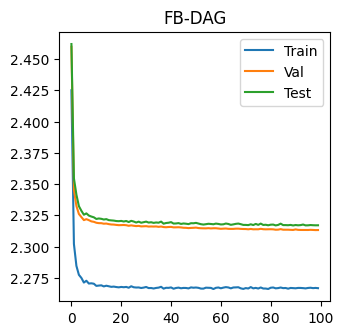

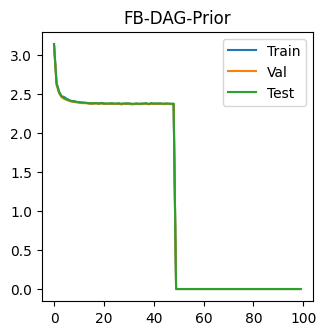

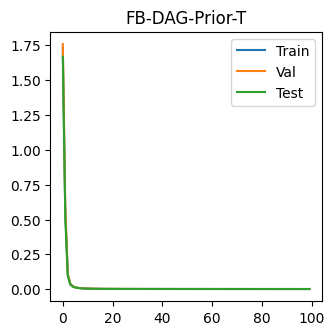

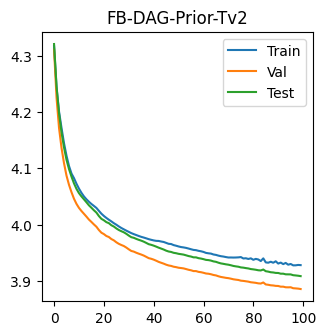

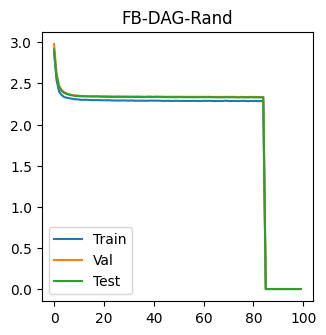

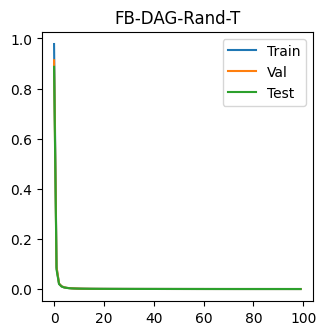

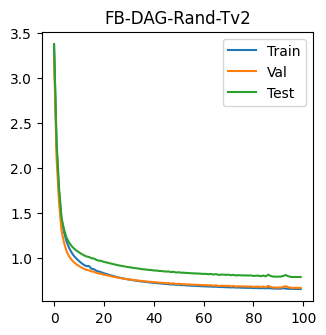

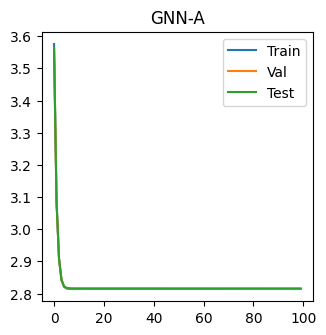

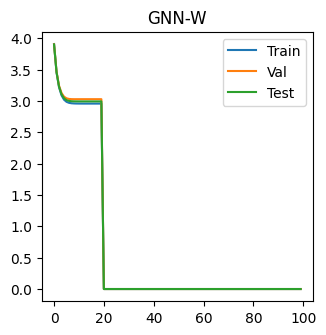

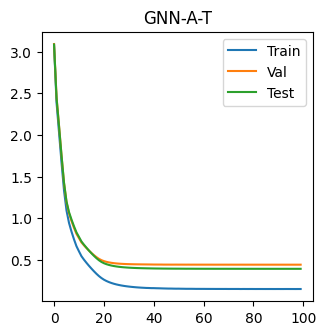

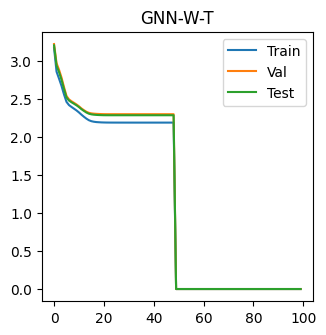

In [46]:
plot_results(results, errs, times, src_id=True, logy=False)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([4, 1, 0, 9, 2, 4, 9, 6, 4, 3, 4, 5, 0, 7, 3, 5, 1, 1, 6, 4])


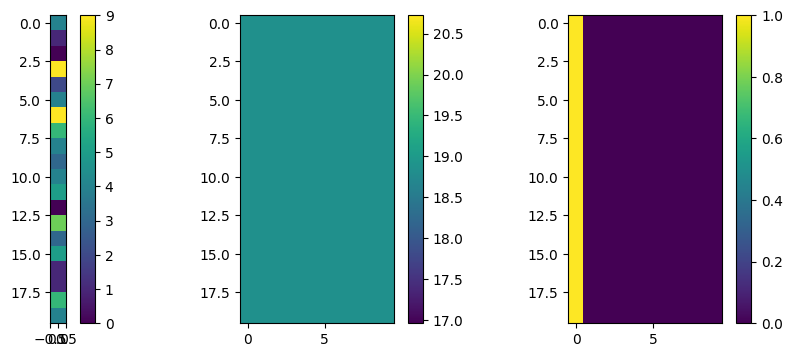

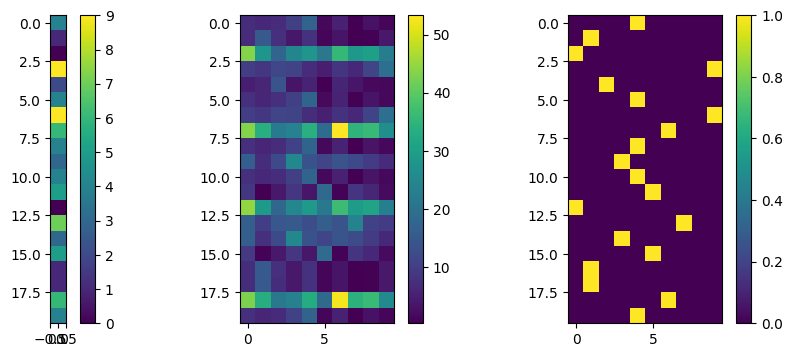

In [47]:
node_idx = 10
samples_idx = 20
plot_GSO = sel_GSOs.to(device=device)
plot_GSO_T = sel_GSOs_T.to(device=device)
data = signals['test'].to(device=device)
labels_hat = model_dag.arch(data, plot_GSO).cpu().detach()
labels_T_hat = model_dag_T.arch(data, plot_GSO_T).cpu().detach()

src_indx = np.argmax(labels['test'], axis=1).squeeze()
src_indx_hat = np.argmax(labels_hat, axis=1).squeeze()
src_indx_T_hat = np.argmax(labels_T_hat, axis=1).squeeze()


labels_th = torch.zeros_like(labels_hat)
labels_th[np.arange(M_test), src_indx_hat] = 1

labels_T_th = torch.zeros_like(labels_T_hat)
labels_T_th[np.arange(M_test), src_indx_T_hat] = 1

print(src_indx[:samples_idx])
print(src_indx_hat[:samples_idx])
print(src_indx_T_hat[:samples_idx])

# With the Original GSO
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(labels['test'][:samples_idx,:node_idx])
plt.colorbar()  

plt.subplot(1,3,2)
plt.imshow(labels_hat[:samples_idx,:node_idx])
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(labels_th[:samples_idx,:node_idx])
plt.colorbar()

# With the Transpose GSO
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(labels['test'][:samples_idx,:node_idx])
plt.colorbar()  

plt.subplot(1,3,2)
plt.imshow(labels_T_hat[:samples_idx,:node_idx])
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(labels_T_th[:samples_idx,:node_idx])
plt.colorbar()